In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 1
L2 = lambda x: x
W = lambda t: WFPS

In [3]:
def F(t, x):
    x_0 = LITTERING_RATE*x[1] - L2(W(t))*x[0]
    x_1 = NUTRIENT_INTAKE_RATE*x[1]*x[2] - LITTERING_RATE*x[1]
    x_2 = L2(W(t))*x[0] - NUTRIENT_INTAKE_RATE*x[1]*x[2]
    
    return [x_0, x_1, x_2]
    
t_eval = np.arange(0, 100, 0.01)
sol = solve_ivp(F, [0, 100], [0.5, 0.5, 0.0], t_eval=t_eval)

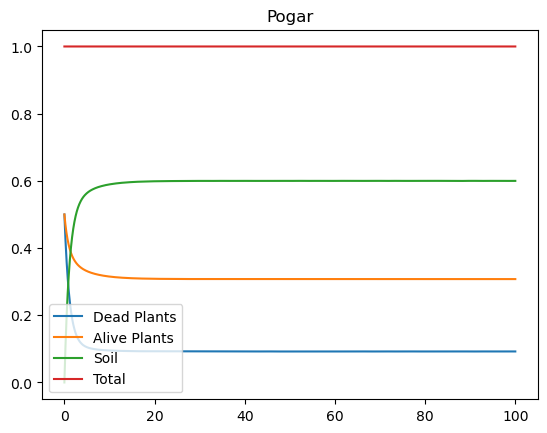

In [4]:
plt.plot(t_eval, sol.y.T[:, 0], label="Dead Plants")
plt.plot(t_eval, sol.y.T[:, 1], label="Alive Plants")
plt.plot(t_eval, sol.y.T[:, 2], label="Soil")
plt.plot(t_eval, sol.y.T[:, 0]+sol.y.T[:, 1]+sol.y.T[:, 2], label="Total")
plt.title("Pogar")
plt.legend()
plt.show()

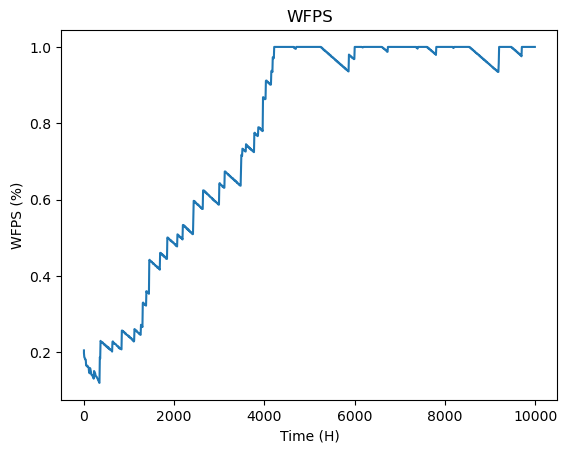

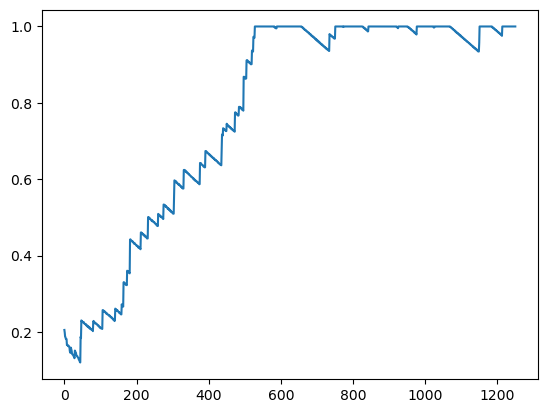

In [167]:
### Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 0.3
L2 = lambda x: x

from water import water

result = water(200, 0, 10000, 1, [0.9, 6, 5], [0.4, 4, 3])
plt.plot(result)

W = lambda t: 0.5

In [220]:
from copy import copy, deepcopy

TIME_PERIOD = 1000
SPECIES_COUNT = 20
NUTRIENT_COUNT = 10
FACTOR = 0.00001

input_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT + 2))

# We now populate our input state
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        input_state[nutrient][species] = np.random.uniform(0.02, 0.08)
        
soil_uptake_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
littering_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
composition = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))

# Populate uptake and littering params
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        soil_uptake_params[nutrient][species] = np.random.uniform(57, 63) * FACTOR
        littering_params[nutrient][species] = np.random.uniform(27, 33) * FACTOR
        
for species in range(SPECIES_COUNT):
    comp = np.random.uniform(0.0, 1.0, (NUTRIENT_COUNT))
    comp /= sum(comp)
    for nutrient in range(NUTRIENT_COUNT):
        composition[nutrient][species] = comp[nutrient]
        

for nutrient in range(NUTRIENT_COUNT):
    input_state[nutrient][-1] = 0.0 # Start off with zero dead plants
    input_state[nutrient][-2] = 0.2 # Start off with 1-P nutrients in the soil
    

In [221]:
  def F(t, state_space):
    state_space = np.reshape(state_space, (NUTRIENT_COUNT, SPECIES_COUNT + 2))
    return_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT+2))
    
    # Calculate limiting nutrient in the soil
    limiting_nutrients = [0] * SPECIES_COUNT
    for species in range(SPECIES_COUNT):
        limiting_nutrient = 0
        for nutrient in range(NUTRIENT_COUNT):
            if composition[nutrient][species] * state_space[nutrient][-2] < state_space[limiting_nutrient][-2]:
                limiting_nutrient = nutrient
        limiting_nutrients[species] = limiting_nutrient
        
    # Calculate Biomass for each species
    biomass = np.empty((SPECIES_COUNT))
    for species in range(SPECIES_COUNT):
        biomass[species] = sum(state_space[:, species])
        # print(biomass[species])
    
    nutrient_uptake_total = np.zeros((NUTRIENT_COUNT))
    littering_total = np.zeros((NUTRIENT_COUNT))
    
    # Calculate plant derivatives
    for nutrient in range(NUTRIENT_COUNT):        
        for species in range(SPECIES_COUNT):
            lim_nut = limiting_nutrients[species]
            
            # Get nutrient uptake
            nutrient_uptake = soil_uptake_params[nutrient][species] * biomass[species] * state_space[lim_nut][species] \
            * (composition[nutrient][species]/composition[lim_nut][species])
            
            # Get littering
            littering = littering_params[nutrient][species] * state_space[nutrient][species]
            
            return_state[nutrient][species] = nutrient_uptake - littering
            
            nutrient_uptake_total[nutrient] += nutrient_uptake
            littering_total[nutrient] += littering
            
            
    # Calculate other derivatives
    for nutrient in range(NUTRIENT_COUNT):
        # Soil
        return_state[nutrient][-2] = L2(W(t))*state_space[nutrient][-1] - nutrient_uptake_total[nutrient]
        
        # Dead
        return_state[nutrient][-1] = littering_total[nutrient] - L2(W(t))*state_space[nutrient][-1]
    
    
    # print(return_state)
    return return_state.flatten()
        
t_eval = np.arange(0, TIME_PERIOD, 0.01)
sol = solve_ivp(F, [0, TIME_PERIOD], input_state.flatten(), t_eval=t_eval)

Text(0, 0.5, 'Relative Biomass')

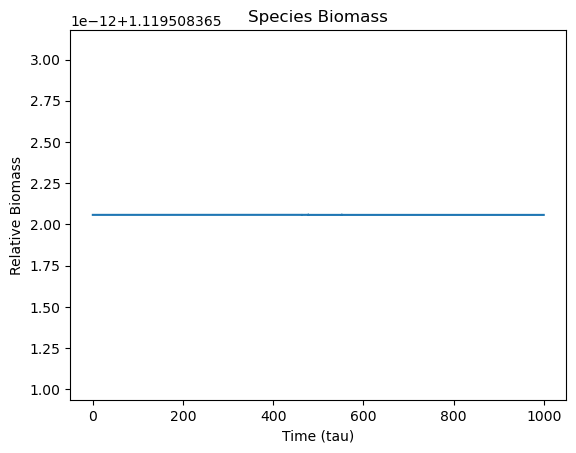

In [226]:
solution = sol.y.reshape((NUTRIENT_COUNT, SPECIES_COUNT+2, TIME_PERIOD*100))
for species in range(SPECIES_COUNT):
    plt.plot(t_eval, sum([nutrient, species, :] for nutrient in range(NUTRIENT_COUNT))
    
plt.title("Species Biomass")
plt.xlabel("Time (tau)")
plt.ylabel("Relative Biomass")